In [ ]:
# -*- coding: utf-8 -*-
"""
Last Edited on Monday, October 17, 2022
Edited by Sapdo Utomo

Created oN MONDAY DEC 2, 2019
Created on Wed Oct 16 16:51:58 2019

@author: Darmawan Utomo
"""

"""
Created on Tue Oct  9 11:22:16 2019

@author: Darmawan Utomo
For Daily Prediction, two clusters,
Created on Mon Oct  10 19:21:15 2019
Univariate_Anomaly08:
    #====================================================================================
    # MODEL: training by changing the LSTM LAYERS, NEURON NUMBERS, ACTIVATION FUN, CONV1D
    #====================================================================================
    #SINGLE-SERI-WITH NORMAL BCS PREVIOUS VERSION HAD REMOVED THE NORMAL DATASET :
    #ABAIKAN CLUSTERING. JUST USED SINGLE COLUMN!
    #Iterate based on INTERVAL/TS, N_PREDICTION_OUTPUT, n_cluster (0&1), crossvalidation=5, CrossVal[0-4], ROC-PR-AUC[0-1]
    #INTERVAL=32,64,128,256,512
    #N_PREDICTION_OUTPUT = 7,14,21,28,35
    #Create Cross Validation
    #Anomaly Flag is generated by selecting value more than mean*3stdev for each smartmeter
    #cluster into 2 Classes
    #For each cluster, group every INTERVAL days into 1 label by running sliding windows
    #Modify the Sliding Windows to capture several events (N PREDICTION)before the real events as Abnormal/anomalous
    #Create option to use/Generate SMOTE to balance dataset between normal and abnormal or not.
    #Reshape into TimeSeries [Frame, Interval, 1]
    #Apply the model, using Conv1D, LSTM
    #Train and Test the model, for 300-1000-->[800] epochs
    #Run AND SAVE metrics evaluation measuring ROC curve and Precision-Recall curve
    #
    okt 18 2019 : 
@author: Darmawan Utomo
"""


In [1]:
#%%

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"


from sklearn.cluster import DBSCAN
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, MaxPooling1D, Conv1D

import numpy as np
from numpy.random import seed
from matplotlib import pyplot as plt
#from sklearn.cross_validation import train_test_split
from scipy.stats import mode
import collections
from keras.models import model_from_json
from tensorflow import set_random_seed

from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import split
from numpy import array


from matplotlib import pyplot
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.ensemble import IsolationForest


from scipy.spatial.distance import euclidean
from sklearn import metrics
from sklearn.cluster import KMeans
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib import colors as mcolors 
import math 
from mpl_toolkits.mplot3d import Axes3D 
import pickle

from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, auc
from datetime import datetime
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
from sklearn.model_selection import StratifiedKFold


Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Check mean3std:  597.0


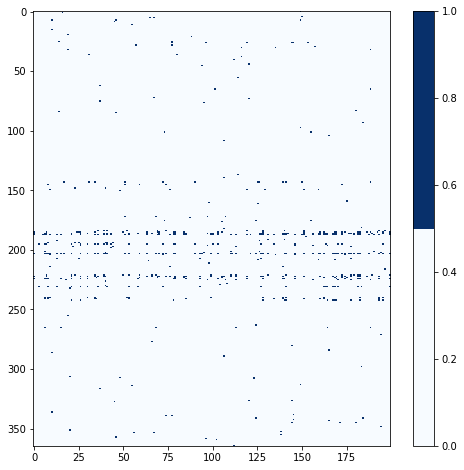

(365, 200) (365, 200) (73000, 1) (73000, 1) (200,) (200,) (200,)
(365, 50) (365, 50) (18250, 1) (18250, 1)


In [2]:
# load dataset and calculate the Anomaly
dataset = read_csv('ResidentialProfiles_days.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')
#scaled = values/np.max(values) #to normalize data to the max values per column
scaled = values/np.max(values, axis =0) #to normalize data to the max values per column #to normalize data to the max values per column
values = scaled

#%%ANOMALY BASED ON STANDARD DEVIATION
val_x, val_y = values.shape

mean3std = np.zeros((val_y),dtype=float)
mean_ax0 = np.mean(values[::,0:200], axis=0)
mstd_ax0 = np.std(values[::,0:200], axis=0)
mean3std = mean_ax0 + 3* mstd_ax0


xn = np.zeros((val_x, val_y))
for i in range(val_y):
    xn[::,i] = (values[::,i] > mean3std[i]).astype(int)

print("Check mean3std: ", np.sum(xn))    
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(xn))
plt.imshow(xn, aspect='auto', interpolation='None',  cmap=plt.cm.get_cmap('Blues', 2))
plt.colorbar()
plt.show()

xn_seri = xn.reshape((xn.shape[0]*xn.shape[1],1), order='F')
values_seri = values.reshape((values.shape[0]*values.shape[1],1), order='F')
print(values.shape, xn.shape, xn_seri.shape, values_seri.shape, mean_ax0.shape, mstd_ax0.shape, mean3std.shape)

ss=np.sum(xn,axis=0) #to find all the numbers of anomalous
loc_ss= np.where(ss==0) #select in the normal data
xnT = xn.T
xn_normalT = xnT[loc_ss]
xn_normal = xn_normalT.T
#serialized the xn_seri based on F order
vT = values.T
values_normalT = vT[loc_ss]
values_normal = values_normalT.T

xn_normal_seri = xn_normal.reshape((xn_normal.shape[0]*xn_normal.shape[1],1), order='F')
values_normal_seri = values_normal.reshape((values_normal.shape[0]*values_normal.shape[1],1), order='F')
print(values_normal.shape, xn_normal.shape, xn_normal_seri.shape, values_normal_seri.shape)




Training200 epochs UA09-SERVER-201X-SERI-WITH-NORMAL-MODEL_1_32_tanh_64_5_10 please wait until finished
Training200 epochs UA09-SERVER-201X-SERI-WITH-NORMAL-MODEL_1_32_tanh_64_5_10 please wait until finished
TRAINED:--> SAVE MODEL-WEIGHT:  UA09-SERVER-201X-SERI-WITH-NORMAL-MODEL_1_32_tanh_64_5_10
DNN------Training Time---------
Epoch 1/200
58287/58287 [==============================] - 2s 37us/step - loss: 0.3312 - acc: 0.9116
Epoch 2/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.2841 - acc: 0.9179
Epoch 3/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.2819 - acc: 0.9179
Epoch 4/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.2780 - acc: 0.9179
Epoch 5/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.2607 - acc: 0.9179
Epoch 6/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.2410 - acc: 0.9177
Epoch 7/200
58287/58287 [==============================] - 1s 18

58287/58287 [==============================] - 1s 18us/step - loss: 0.0981 - acc: 0.9617
Epoch 79/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0975 - acc: 0.9616
Epoch 80/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0967 - acc: 0.9612
Epoch 81/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0938 - acc: 0.9629
Epoch 82/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.0917 - acc: 0.9626
Epoch 83/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.0923 - acc: 0.9630
Epoch 84/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.0922 - acc: 0.9631
Epoch 85/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.0904 - acc: 0.9640
Epoch 86/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0904 - acc: 0.9643
Epoch 87/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0875 - acc: 

58287/58287 [==============================] - 1s 17us/step - loss: 0.0545 - acc: 0.9781
Epoch 158/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0525 - acc: 0.9792
Epoch 159/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0535 - acc: 0.9791
Epoch 160/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0511 - acc: 0.9803
Epoch 161/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.0533 - acc: 0.9788
Epoch 162/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0524 - acc: 0.9792
Epoch 163/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.0528 - acc: 0.9792
Epoch 164/200
58287/58287 [==============================] - 1s 18us/step - loss: 0.0534 - acc: 0.9790
Epoch 165/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.0514 - acc: 0.9800
Epoch 166/200
58287/58287 [==============================] - 1s 17us/step - loss: 0.051

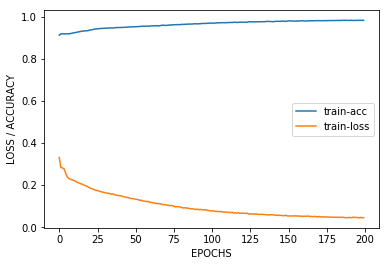

Saved model-UA09-SERVER-201X-SERI-WITH-NORMAL-MODEL_1_32_tanh_64_5_10 to disk
14572/14572 [==============================] - 3s 208us/step
(2288,) (2288,)


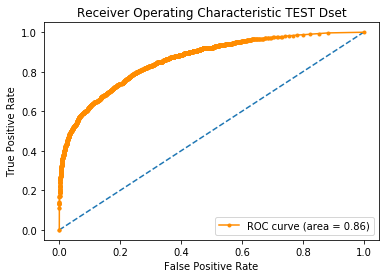

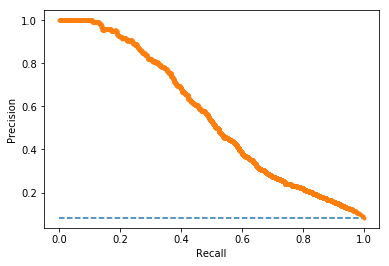

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-SERVER-201X-SERI-WITH-NORMAL-MODEL_1_32_tanh_64_5_10 ROC-AUC: 0.862 PR-AUC: 0.555


In [5]:

#if n_input=7 dan n_out=7, it's mean input = 7 days, output = next 7 days (label)
#This to_supervised3 function from machinelearningmastery Jason Brownlee, Ph.D.
def to_supervised3(X, y, train, label, n_input, n_pred_out=7): 
	# flatten data
	data = train #.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	#X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_pred_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end]); maxlabel = max(label[in_end:out_end])
			y.append(maxlabel) #only one label
		# move along one time step
		in_start += 1
	return array(X), array(y)


#%%
#IMPORTANT VARIABLES !!!!AS FEATURES
#I hope your machine has enough resources
from numpy import load, save
#Sapdo, check this Dir
#DIR = './/DNN_MODEL_WEIGHT/'
DIR = './'

#auc_roc_pr[INTERVAL, N_PRED_OUT, cluster_no,n_crossvalidation, SPLIT_NO, roc-pr-auc]
auc_roc_pr = np.zeros((3,3,4,3,10,5,6))
ii=jj=kk=ll=0
INTERVAL =128
N_PRED_OUT=14
N_OUT = 1
for LSTM_LAYERS in [1]: #ONLY TESTED FOR 3 LAYERS [1,2,3]
    for NEURON in [32]: #[32, 64,256,1024]
        for ACT_FUN in ['tanh']: #['tanh', 'sigmoid', 'relu', 'hard_sigmoid']
            for CONV1D in [64]:
                
                
                X0,y0 = list(), list()
                to_supervised3(X0, y0, values_seri, xn_seri, INTERVAL, N_PRED_OUT)

                X0 = np.array(X0) #make sure all in numpys, not in lists
                y0 = np.array(y0)
                y0 = y0.reshape((y0.shape[0],1)) #make shape to (n_labels,1)


                #DataValueLabel = np.append(X0,y0, axis=1)

                # Change the variabel data  --> data = DataVAlueLabel1/2/3/blank
                NUMCLASSMEMBERS = 1 # only using 1 features
                SPLIT_NO = 0

                DataNonSmoteX = X0
                DataNonSmotey = y0

                n_crossvalidation=5
                skf = StratifiedKFold(n_splits=n_crossvalidation)
                train_all=[]
                test_all=[]
                for train, test in skf.split(DataNonSmoteX, DataNonSmotey):
                    train_all.append(train)
                    test_all.append(test)
                #for SPLIT_NO in range(n_crossvalidation):
                for SPLIT_NO in range(1):
                    
                    Data2kCrossValTrainx = DataNonSmoteX[train_all[SPLIT_NO]]
                    Data2kCrossValTrainy = DataNonSmotey[train_all[SPLIT_NO]]
                    w1 = np.where(Data2kCrossValTrainy==1)
                    RANDOM_INDEX = random.sample(range(Data2kCrossValTrainx.shape[0]),Data2kCrossValTrainx.shape[0])
                    Data2kCrossValTrainx = Data2kCrossValTrainx[RANDOM_INDEX]
                    Data2kCrossValTrainy = Data2kCrossValTrainy[RANDOM_INDEX]


                    Data2kCrossValTestx = DataNonSmoteX[test_all[SPLIT_NO]]
                    Data2kCrossValTesty = DataNonSmotey[test_all[SPLIT_NO]]
                    w0 = np.where(Data2kCrossValTesty==1)
                    RANDOM_INDEX = random.sample(range(Data2kCrossValTestx.shape[0]),Data2kCrossValTestx.shape[0])
                    Data2kCrossValTestx = Data2kCrossValTestx[RANDOM_INDEX]
                    Data2kCrossValTesty = Data2kCrossValTesty[RANDOM_INDEX]
                    Data2kCrossValTestx = Data2kCrossValTestx.reshape((Data2kCrossValTestx.shape[0],Data2kCrossValTestx.shape[1],1))
                    #print( len(w1[0]), len(w0[0]))

                    #sm = SMOTE(random_state=42)
                    #X = DataValueLabel3[:,:INTERVAL]
                    #y = DataValueLabel3[:,INTERVAL]
                    #X_res, y_res = sm.fit_resample(X, y)
                    #print('Resampled dataset shape %s' % Counter(y_res))
                    SMOTE_IN = False #True #if u want to use SMOTE
                    if (SMOTE_IN) :
                        sm = SMOTE(random_state=42)
                        X = Data2kCrossValTrainx
                        y = Data2kCrossValTrainy
                        X_res, y_res = sm.fit_resample(X, y)
                        print('SPLIT NO: ',SPLIT_NO, 'Resampled dataset shape %s' % Counter(y_res))

                        y=y_res.reshape(y_res.shape[0],1) #format ke y(:,1)
                        #Random data first than combine. DataSmote = np.append(X_res,y, axis=1) # append supaya jadi [Xy] 
                        DataSmoteX= X_res
                        DataSmotey = y
                        RANDOM_INDEX = random.sample(range(DataSmoteX.shape[0]),DataSmoteX.shape[0])


                        #print(RANDOM_INDEX)
                        DataSmoteX = DataSmoteX[RANDOM_INDEX]
                        DataSmotey = DataSmotey[RANDOM_INDEX]
                        #change to timeseries format data
                        DataSmoteX = DataSmoteX.reshape((DataSmoteX.shape[0],DataSmoteX.shape[1],1))

                        #Split Dataset
                        #tx, tsx, ytrain, ytest = train_test_split(DataSmoteX,DataSmotey, test_size=0.2, random_state=42)
                        tx = DataSmoteX
                        ytrain = DataSmotey
                        tsx = Data2kCrossValTestx
                        ytest = Data2kCrossValTesty
                    else:
                        Data2kCrossValTrainx = Data2kCrossValTrainx.reshape((Data2kCrossValTrainx.shape[0],Data2kCrossValTrainx.shape[1],1))    
                        tx = Data2kCrossValTrainx
                        ytrain = Data2kCrossValTrainy
                        tsx = Data2kCrossValTestx
                        ytest = Data2kCrossValTesty
                        #print(tx.shape, ytrain.shape, tsx.shape, ytest.shape)

                    N_TRAIN_MOVIES = tx.shape[0]
                    N_TEST_MOVIES = tsx.shape[0]
                    INTERVAL = tx.shape[1]


                    BATCHSIZE=365 * 4

                    model = Sequential()
                    model.add(Conv1D(4, 3, strides=3, activation=ACT_FUN, input_shape=(INTERVAL, NUMCLASSMEMBERS)))
                    model.add(Conv1D(8, 3, padding="same",activation=ACT_FUN))
                    model.add(MaxPooling1D(1))
                    model.add(Conv1D(16, 5,padding="same", activation=ACT_FUN))
                    model.add(MaxPooling1D(1))

                    model.add(Conv1D(32, 7,padding="same", activation=ACT_FUN))
                    model.add(MaxPooling1D(3))
                    model.add(Conv1D(64, 7,padding="same", activation=ACT_FUN))
                    model.add(MaxPooling1D(3))

                    model.add(Dropout(0.5))

                    model.add(LSTM(NEURON,batch_input_shape=(BATCHSIZE,INTERVAL, NUMCLASSMEMBERS)))

                    model.add(Dense(N_OUT, activation='sigmoid'))

                    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

                    EPOCH = 200
                    NO = 'UA09-SERVER-201X-SERI-WITH-NORMAL-MODEL'+'_'+str(LSTM_LAYERS)+'_'+str(NEURON)+'_'+str(ACT_FUN)+'_'+str(CONV1D)+'_'+str(n_crossvalidation)+'_'+str(SPLIT_NO+1)+str(int(SMOTE_IN)) # 500 untuk 2 cluster[1] 

#Notes: STATUS = "LOAD" for Testing, STATUS = "SAVE" for Training 
                    STATUS = "LOAD" #or else i.e: 'LOAD'
                    #STATUS = "SAVE" #or else i.e: 'LOAD'

                    if STATUS == "SAVE" :

                        print('Training' + str(EPOCH) +' epochs '+ NO  +' please wait until finished')

                        
                        print('Training' + str(EPOCH) +' epochs '+ NO  +' please wait until finished')
                        print('TRAINED:--> SAVE MODEL-WEIGHT: ', NO)
                        print('DNN------Training Time---------',)
                        then  = datetime.now() 
                        history = model.fit(tx[:N_TRAIN_MOVIES], ytrain[:N_TRAIN_MOVIES],
                                  batch_size=BATCHSIZE, epochs=EPOCH, shuffle=True, verbose=1)

                        now  = datetime.now() 
                        duration = now - then
                        print("DNN Duration per-train sample %6.3f" %(1000*duration.total_seconds()/ N_TRAIN_MOVIES), ' ms')
                        print('DNN TOTAL TRAINING SAMPLES: ', N_TRAIN_MOVIES,'Training Duration %6.3f' %(duration.total_seconds()), ' s')
            
            
                        #history = model.fit(tx[:N_TRAIN_MOVIES], ytrain[:N_TRAIN_MOVIES],
                        #batch_size=BATCHSIZE, epochs=EPOCH, shuffle=True, verbose=0)
                        #print(history.history.keys())
                        plt.plot(history.history['acc'], label='train-acc')
                        plt.plot(history.history['loss'], label='train-loss')
                        plt.xlabel('EPOCHS')
                        plt.ylabel('LOSS / ACCURACY')
                        plt.legend(loc="lower right")
                        plt.legend()    
                        plt.savefig("./cluster_pdf/"+NO+"-Loss.png")
                        plt.show()

                        # serialize model to JSON
                        model_json = model.to_json()
                        with open(DIR + "DNN_CL"+ NO +".json", "w") as json_file:
                            json_file.write(model_json)
                        # serialize weights to HDF5
                        model.save_weights(DIR + "DNN_CL" + NO +".h5")
                        print("Saved model-" + NO + " to disk")

                    else : #test = "Load" # load json and create model
                        print('Testing ' + str(EPOCH) +' epochs '+ NO  +' please wait until finished')
                        json_file = open(DIR + "DNN_CL"+ NO +".json", 'r')
                        loaded_model_json = json_file.read()
                        json_file.close()
                        model = model_from_json(loaded_model_json)
                        # load weights into new model
                        model.load_weights(DIR + "DNN_CL"+ NO +".h5")
                        print("Loaded model-" + "DNN_CL"+ NO +".h5" + " and weight"+"DNN_CL"+ NO +".json"+" from disk")

                    probs = model.predict(tsx, verbose=1)
                    # calculate AUC
                    rocauc = roc_auc_score(ytest, probs)
                    # calculate roc curve
                    fpr, tpr, thresholds = roc_curve(ytest, probs)
                    ## plot naive
                    plt.plot([0, 1], [0, 1], linestyle='--')
                    ## plot the roc curve for the model
                    plt.plot(fpr, tpr, marker='.',color='darkorange', label='ROC curve (area = %0.2f)' % rocauc)
                    print(tpr.shape,fpr.shape)
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic TEST Dset')
                    plt.legend(loc="lower right")
                    ## show the plot
                    plt.savefig("./cluster_pdf/"+NO+"-ROC.png")
                    plt.show()

                    ##PRECISION RECALL TESTING
                    pos = np.sum(ytest)
                    neg = ytest.shape[0]-pos
                    precision, recall, thresholds = precision_recall_curve(ytest, probs)
                    auc_score = auc(recall, precision)
                    pyplot.plot([0, 1], [pos/ytest.shape[0], pos/ytest.shape[0]], linestyle='--')
                    pyplot.plot(recall, precision, marker='.')
                    plt.xlabel('Recall')
                    plt.ylabel('Precision')
                    plt.savefig("./cluster_pdf/"+NO+"-PR.png")
                    pyplot.show()
                    print(tx.shape, ytrain.shape, tsx.shape, ytest.shape)
                    print('Abnormal: ',str(pos), ' Normal: ', str(neg), NO,'ROC-AUC: %.3f' % rocauc, 'PR-AUC: %.3f' % auc_score)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,0] = rocauc
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,1] = auc_score
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,2] = np.sum(ytest==1)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,3] = np.sum(ytest==0)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,4] = np.sum(ytrain==1)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,5] = np.sum(ytrain==0)              
                    save('DATA_LSTM_auc_roc_pr.npy',auc_roc_pr)


                    del model
                ll=ll+1 #conv1d=16,32,64
            kk=kk+1 #act_fun = tanh, sigmoid, relu, hard_sigmoid
            ll=0
        jj=jj+1 # untuk menyimpan NEURON NUMBER = 64,128,256,512,1024
        kk=0
    jj=0
    ii=ii+1 # untuk menyimpan LSTM LAYERS =1,2,3
        


Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_10 please wait until finished


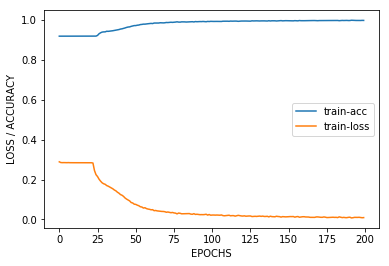

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_10 to disk
14572/14572 [==============================] - 8s 548us/step
(2198,) (2198,)


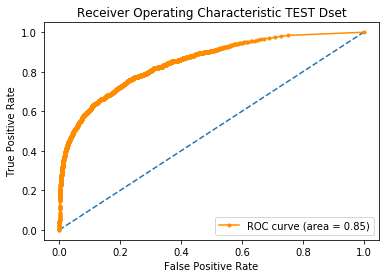

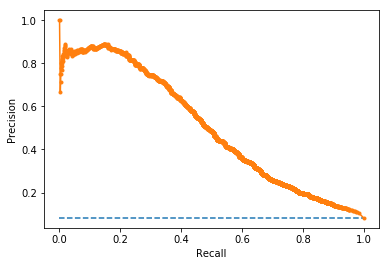

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_10 ROC-AUC: 0.849 PR-AUC: 0.502
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_20 please wait until finished


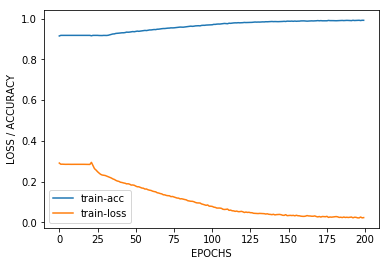

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_20 to disk
14572/14572 [==============================] - 8s 528us/step
(2634,) (2634,)


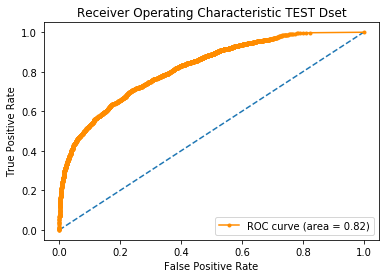

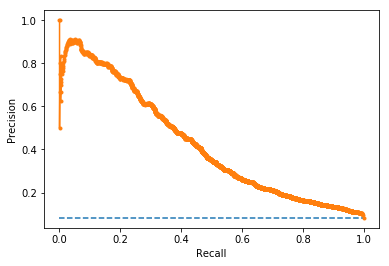

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_20 ROC-AUC: 0.821 PR-AUC: 0.426
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_30 please wait until finished


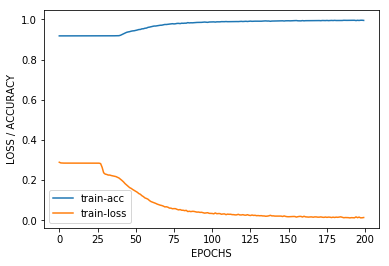

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_30 to disk
14572/14572 [==============================] - 8s 566us/step
(2283,) (2283,)


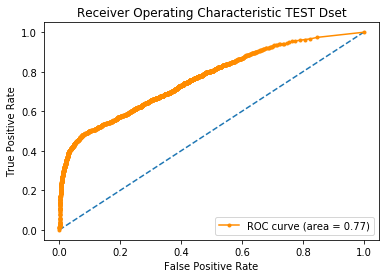

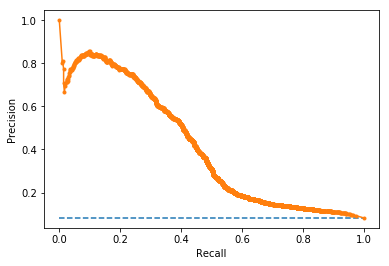

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_30 ROC-AUC: 0.766 PR-AUC: 0.408
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_40 please wait until finished


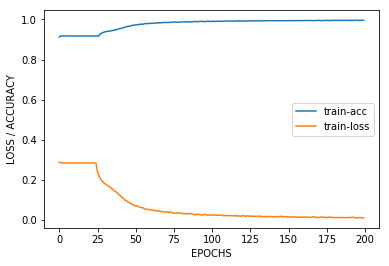

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_40 to disk
14572/14572 [==============================] - 8s 555us/step
(2212,) (2212,)


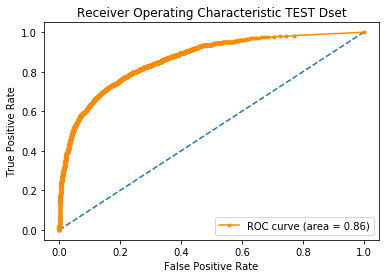

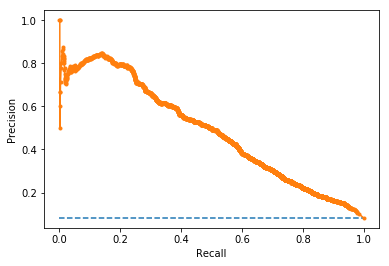

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_40 ROC-AUC: 0.864 PR-AUC: 0.485
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_50 please wait until finished


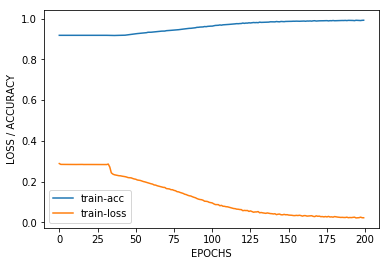

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_50 to disk
14571/14571 [==============================] - 8s 557us/step
(2490,) (2490,)


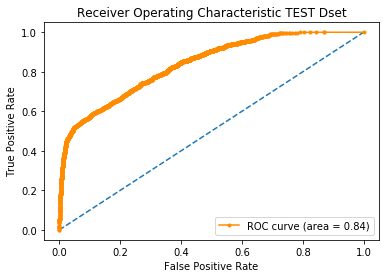

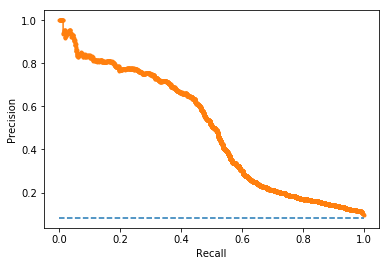

(58288, 128, 1) (58288, 1) (14571, 128, 1) (14571, 1)
Abnormal:  1196.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_50 ROC-AUC: 0.838 PR-AUC: 0.490
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_10 please wait until finished


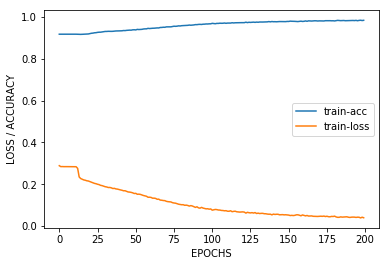

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_10 to disk
14572/14572 [==============================] - 6s 396us/step
(2433,) (2433,)


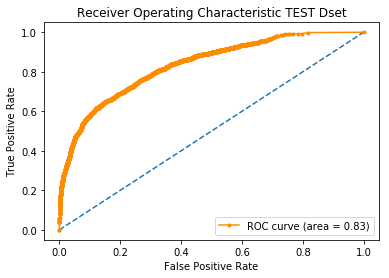

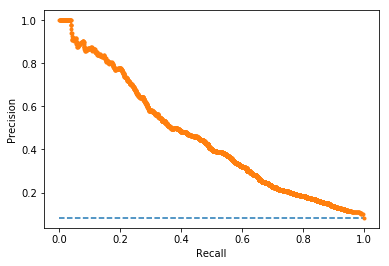

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_10 ROC-AUC: 0.835 PR-AUC: 0.453
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_20 please wait until finished


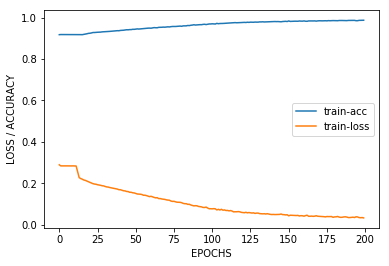

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_20 to disk
14572/14572 [==============================] - 6s 412us/step
(2434,) (2434,)


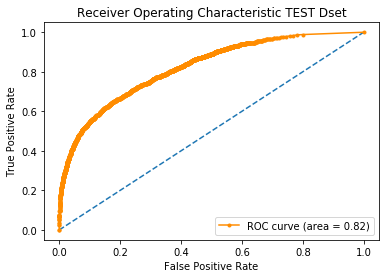

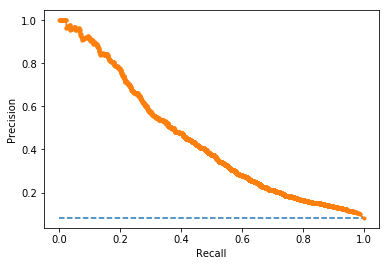

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_20 ROC-AUC: 0.822 PR-AUC: 0.443
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_30 please wait until finished


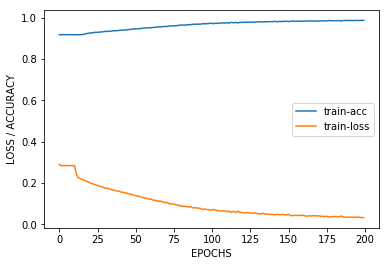

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_30 to disk
14572/14572 [==============================] - 6s 424us/step
(2510,) (2510,)


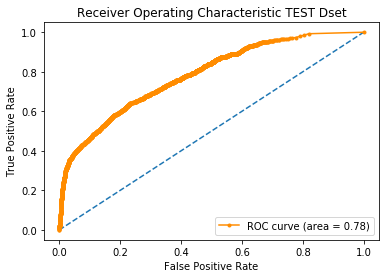

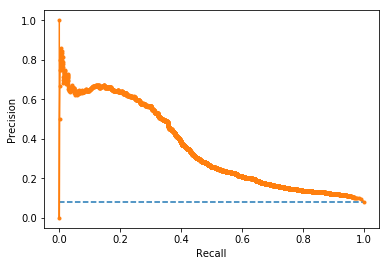

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_30 ROC-AUC: 0.784 PR-AUC: 0.353
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_40 please wait until finished


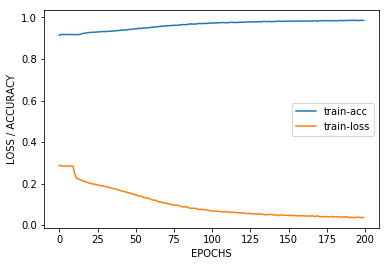

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_40 to disk
14572/14572 [==============================] - 6s 413us/step
(2554,) (2554,)


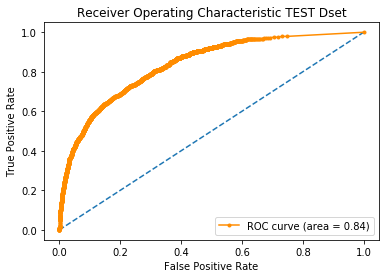

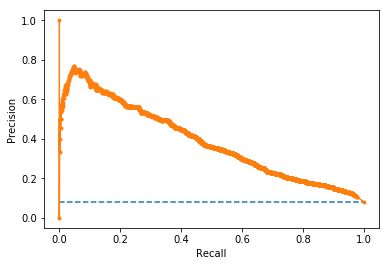

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_40 ROC-AUC: 0.836 PR-AUC: 0.387
Training200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_50 please wait until finished


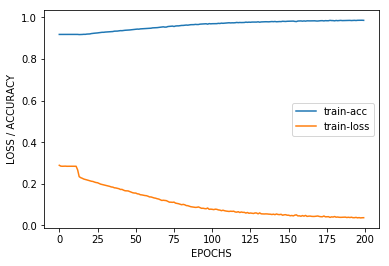

Saved model-UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_50 to disk
14571/14571 [==============================] - 6s 427us/step
(2451,) (2451,)


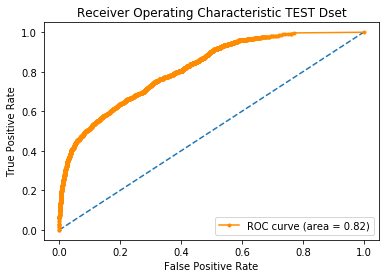

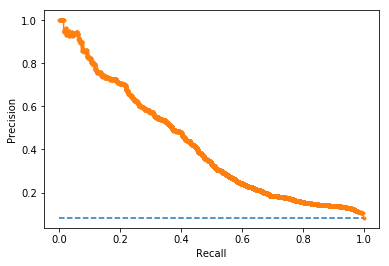

(58288, 128, 1) (58288, 1) (14571, 128, 1) (14571, 1)
Abnormal:  1196.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_50 ROC-AUC: 0.817 PR-AUC: 0.417


In [23]:
#This to_supervised3 function from machinelearningmastery Jason Brownlee, Ph.D.
def to_supervised3(X, y, train, label, n_input, n_pred_out=7): 
	# flatten data
	data = train #.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	#X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_pred_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end]); maxlabel = max(label[in_end:out_end])
			y.append(maxlabel) #only one label
		# move along one time step
		in_start += 1
	return array(X), array(y)


#%%
#IMPORTANT VARIABLES !!!!AS FEATURES
#I hope your machine has enough resources

#Sapdo, check this Dir
#DIR = './/DNN_MODEL_WEIGHT/'
DIR = './'

#auc_roc_pr[INTERVAL, N_PRED_OUT, cluster_no,n_crossvalidation, SPLIT_NO, roc-pr-auc]
auc_roc_pr = np.zeros((3,3,4,3,10,5,6))
ii=jj=kk=ll=0
INTERVAL =128
N_PRED_OUT=14
N_OUT = 1
for LSTM_LAYERS in [1]: #ONLY TESTED FOR 3 LAYERS [1,2,3]
    for NEURON in [1024]: #[64,256,1024]
        for ACT_FUN in ['hard_sigmoid']: #['tanh', 'sigmoid', 'relu', 'hard_sigmoid']
            for CONV1D in [32,64]:
                
                
                X0,y0 = list(), list()
                to_supervised3(X0, y0, values_seri, xn_seri, INTERVAL, N_PRED_OUT)

                X0 = np.array(X0) #make sure all in numpys, not in lists
                y0 = np.array(y0)
                y0 = y0.reshape((y0.shape[0],1)) #make shape to (n_labels,1)


                #DataValueLabel = np.append(X0,y0, axis=1)

                # Change the variabel data  --> data = DataVAlueLabel1/2/3/blank
                NUMCLASSMEMBERS = 1 # only using 1 features
                SPLIT_NO = 0

                DataNonSmoteX = X0
                DataNonSmotey = y0

                n_crossvalidation=5
                skf = StratifiedKFold(n_splits=n_crossvalidation)
                train_all=[]
                test_all=[]
                for train, test in skf.split(DataNonSmoteX, DataNonSmotey):
                    train_all.append(train)
                    test_all.append(test)
                for SPLIT_NO in range(n_crossvalidation):
                    if (ACT_FUN==32) and (CONV1D==32) and (SPLIT_NO in [0,1,2]) :
                        continue
                    Data2kCrossValTrainx = DataNonSmoteX[train_all[SPLIT_NO]]
                    Data2kCrossValTrainy = DataNonSmotey[train_all[SPLIT_NO]]
                    w1 = np.where(Data2kCrossValTrainy==1)
                    RANDOM_INDEX = random.sample(range(Data2kCrossValTrainx.shape[0]),Data2kCrossValTrainx.shape[0])
                    Data2kCrossValTrainx = Data2kCrossValTrainx[RANDOM_INDEX]
                    Data2kCrossValTrainy = Data2kCrossValTrainy[RANDOM_INDEX]


                    Data2kCrossValTestx = DataNonSmoteX[test_all[SPLIT_NO]]
                    Data2kCrossValTesty = DataNonSmotey[test_all[SPLIT_NO]]
                    w0 = np.where(Data2kCrossValTesty==1)
                    RANDOM_INDEX = random.sample(range(Data2kCrossValTestx.shape[0]),Data2kCrossValTestx.shape[0])
                    Data2kCrossValTestx = Data2kCrossValTestx[RANDOM_INDEX]
                    Data2kCrossValTesty = Data2kCrossValTesty[RANDOM_INDEX]
                    Data2kCrossValTestx = Data2kCrossValTestx.reshape((Data2kCrossValTestx.shape[0],Data2kCrossValTestx.shape[1],1))
                    #print( len(w1[0]), len(w0[0]))

                    #sm = SMOTE(random_state=42)
                    #X = DataValueLabel3[:,:INTERVAL]
                    #y = DataValueLabel3[:,INTERVAL]
                    #X_res, y_res = sm.fit_resample(X, y)
                    #print('Resampled dataset shape %s' % Counter(y_res))
                    SMOTE_IN = False #True #if u want to use SMOTE
                    if (SMOTE_IN) :
                        sm = SMOTE(random_state=42)
                        X = Data2kCrossValTrainx
                        y = Data2kCrossValTrainy
                        X_res, y_res = sm.fit_resample(X, y)
                        print('SPLIT NO: ',SPLIT_NO, 'Resampled dataset shape %s' % Counter(y_res))

                        y=y_res.reshape(y_res.shape[0],1) #format ke y(:,1)
                        #Random data first than combine. DataSmote = np.append(X_res,y, axis=1) # append supaya jadi [Xy] 
                        DataSmoteX= X_res
                        DataSmotey = y
                        RANDOM_INDEX = random.sample(range(DataSmoteX.shape[0]),DataSmoteX.shape[0])


                        #print(RANDOM_INDEX)
                        DataSmoteX = DataSmoteX[RANDOM_INDEX]
                        DataSmotey = DataSmotey[RANDOM_INDEX]
                        #change to timeseries format data
                        DataSmoteX = DataSmoteX.reshape((DataSmoteX.shape[0],DataSmoteX.shape[1],1))

                        #Split Dataset
                        #tx, tsx, ytrain, ytest = train_test_split(DataSmoteX,DataSmotey, test_size=0.2, random_state=42)
                        tx = DataSmoteX
                        ytrain = DataSmotey
                        tsx = Data2kCrossValTestx
                        ytest = Data2kCrossValTesty
                    else:
                        Data2kCrossValTrainx = Data2kCrossValTrainx.reshape((Data2kCrossValTrainx.shape[0],Data2kCrossValTrainx.shape[1],1))    
                        tx = Data2kCrossValTrainx
                        ytrain = Data2kCrossValTrainy
                        tsx = Data2kCrossValTestx
                        ytest = Data2kCrossValTesty
                        #print(tx.shape, ytrain.shape, tsx.shape, ytest.shape)

                    N_TRAIN_MOVIES = tx.shape[0]
                    N_TEST_MOVIES = tsx.shape[0]
                    INTERVAL = tx.shape[1]


                    BATCHSIZE=90 * 4
                    model = Sequential()

                    
                    model.add(Conv1D(4, 3, strides=3, activation=ACT_FUN, input_shape=(INTERVAL, NUMCLASSMEMBERS)))
                    model.add(Conv1D(8, 3, padding="same",activation=ACT_FUN))
                    model.add(MaxPooling1D(1))
                    model.add(Conv1D(16, 5,padding="same", activation=ACT_FUN))
                    model.add(MaxPooling1D(1))
                    if CONV1D >=32:
                        model.add(Conv1D(32, 7,padding="same", activation=ACT_FUN))
                        model.add(MaxPooling1D(3))
                    if CONV1D >=64:
                        model.add(Conv1D(64, 7,padding="same", activation=ACT_FUN))
                        model.add(MaxPooling1D(3))
                    
                    model.add(Dropout(0.5))
                    
                    model.add(LSTM(NEURON, batch_input_shape=(BATCHSIZE,INTERVAL, NUMCLASSMEMBERS)))
                    if LSTM_LAYERS == 2:
                        model.add(LSTM(NEURON))    
                      
                    if LSTM_LAYERS == 3:
                        model.add(LSTM(NEURON, return_sequences=True))
                        model.add(LSTM(NEURON))    
                        
                    model.add(Dense(N_OUT, activation='sigmoid'))

                    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

                    EPOCH = 200
                    NO = 'UA09-200X-SERI-WITH-NORMAL-MODEL'+'_'+str(LSTM_LAYERS)+'_'+str(NEURON)+'_'+str(ACT_FUN)+'_'+str(CONV1D)+'_'+str(n_crossvalidation)+'_'+str(SPLIT_NO+1)+str(int(SMOTE_IN)) # 500 untuk 2 cluster[1] 

#Notes: STATUS = "LOAD" for Testing, STATUS = "SAVE" for Training 
                    STATUS = "LOAD" #or else i.e: 'LOAD'
                    #STATUS = "SAVE" #or else i.e: 'LOAD'

                    if STATUS == "SAVE" :

                        print('Training' + str(EPOCH) +' epochs '+ NO  +' please wait until finished')

                        history = model.fit(tx[:N_TRAIN_MOVIES], ytrain[:N_TRAIN_MOVIES],
                                  batch_size=BATCHSIZE, epochs=EPOCH, shuffle=True, verbose=0)
                        #print(history.history.keys())
                        plt.plot(history.history['acc'], label='train-acc')
                        plt.plot(history.history['loss'], label='train-loss')
                        plt.xlabel('EPOCHS')
                        plt.ylabel('LOSS / ACCURACY')
                        plt.legend(loc="lower right")
                        plt.legend()    
                        plt.savefig("./cluster_pdf/"+NO+"-Loss.png")
                        plt.show()

                        # serialize model to JSON
                        model_json = model.to_json()
                        with open(DIR + "DNN_CL"+ NO +".json", "w") as json_file:
                            json_file.write(model_json)
                        # serialize weights to HDF5
                        model.save_weights(DIR + "DNN_CL" + NO +".h5")
                        print("Saved model-" + NO + " to disk")

                    else : #test = "Load" # load json and create model
                        print('Testing ' + str(EPOCH) +' epochs '+ NO  +' please wait until finished')
                        json_file = open(DIR + "DNN_CL"+ NO +".json", 'r')
                        loaded_model_json = json_file.read()
                        json_file.close()
                        model = model_from_json(loaded_model_json)
                        # load weights into new model
                        model.load_weights(DIR + "DNN_CL"+ NO +".h5")
                        print("Loaded model-" + "DNN_CL"+ NO +".h5" + " and weight"+"DNN_CL"+ NO +".json"+" from disk")

                    probs = model.predict(tsx, verbose=1)
                    # calculate AUC
                    rocauc = roc_auc_score(ytest, probs)
                    # calculate roc curve
                    fpr, tpr, thresholds = roc_curve(ytest, probs)
                    ## plot naive
                    plt.plot([0, 1], [0, 1], linestyle='--')
                    ## plot the roc curve for the model
                    plt.plot(fpr, tpr, marker='.',color='darkorange', label='ROC curve (area = %0.2f)' % rocauc)
                    print(tpr.shape,fpr.shape)
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic TEST Dset')
                    plt.legend(loc="lower right")
                    ## show the plot
                    plt.savefig("./cluster_pdf/"+NO+"-ROC.png")
                    plt.show()

                    ##PRECISION RECALL TESTING
                    pos = np.sum(ytest)
                    neg = ytest.shape[0]-pos
                    precision, recall, thresholds = precision_recall_curve(ytest, probs)
                    auc_score = auc(recall, precision)
                    pyplot.plot([0, 1], [pos/ytest.shape[0], pos/ytest.shape[0]], linestyle='--')
                    pyplot.plot(recall, precision, marker='.')
                    plt.xlabel('Recall')
                    plt.ylabel('Precision')
                    plt.savefig("./cluster_pdf/"+NO+"-PR.png")
                    pyplot.show()
                    print(tx.shape, ytrain.shape, tsx.shape, ytest.shape)
                    print('Abnormal: ',str(pos), ' Normal: ', str(neg), NO,'ROC-AUC: %.3f' % rocauc, 'PR-AUC: %.3f' % auc_score)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,0] = rocauc
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,1] = auc_score
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,2] = np.sum(ytest==1)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,3] = np.sum(ytest==0)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,4] = np.sum(ytrain==1)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,5] = np.sum(ytrain==0)              
                    

                    del model
                ll=ll+1 #conv1d=16,32,64
            kk=kk+1 #act_fun = tanh, sigmoid, relu, hard_sigmoid
            ll=0
        jj=jj+1 # untuk menyimpan NEURON NUMBER = 64,128,256,512,1024
        kk=0
    jj=0
    ii=ii+1 # untuk menyimpan LSTM LAYERS =1,2,3
        


In [24]:
#0=LSTM-Layers= [1], 1=Neuron Numbers [64,256,1024], 
#2=Activation Function [tanh,sigmoid,relu,hardsigmoid], 3=Conv1D [16,16-32,16-32-64]
#(auc_roc_pr[0,:3,:4,:3,5,:,:2])

#averaging for each coloumn and for each ROC and PR
# 4 ts, 5 sw_out, 2 auc_roc, and auc_pr values
auc_roc_pr_avg = np.zeros((3,4,3,2)) 
for lstm_index in range(1):
    for neuron_index in range(3):
        for act_fun_index in range(4):        #for kfold in range(5):
            for conv1d_index in range(3):        #for kfold in range(5):
                
#for lstm_index in range(1):
#    for neuron_index in [2]:
#        for act_fun_index in [2]:        #for kfold in range(5):
#            for conv1d_index in [2]:        #for kfold in range(5):

                auc_roc_pr_avg[neuron_index,act_fun_index, conv1d_index,0] = \
                     np.mean(auc_roc_pr[0,neuron_index,act_fun_index,conv1d_index,5,:5,0])
                
                auc_roc_pr_avg[neuron_index,act_fun_index, conv1d_index,1] =  \
                     np.mean(auc_roc_pr[0,neuron_index,act_fun_index,conv1d_index,5,:5,1])

print(auc_roc_pr_avg.T)


[[[[0.82749004 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.81861196 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]]


 [[[0.46217429 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.41038222 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]]]


In [25]:
from numpy import savez_compressed, load, save
save('DATA_LSTM1_auc_roc_pr.npy',auc_roc_pr)
save('DATA_LSTM1_auc_roc_pr_avg.npy',auc_roc_pr_avg)
datay = load('DATA_LSTM1_auc_roc_pr.npy')
datayavg = load('DATA_LSTM1_auc_roc_pr_avg.npy')

print('AFTER AVERAGING THE K=5 VALUES')
print(datayavg.T)
print('ORIGNAL DATA BEFORE AVERAGING THE K=5 VALUES')
print(datay[0,:3,:4,:3,5,:,:2])

AFTER AVERAGING THE K=5 VALUES
[[[[0.82749004 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.81861196 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]]


 [[[0.46217429 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.41038222 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]]]
ORIGNAL DATA BEFORE AVERAGING THE K=5 VALU

In [ ]:
"FOR TESTING NORMAL DATA, WETHER IT WILL PREDICT ANOMALY OR ALWAYS NORMAL?"

Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_10 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_10.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_10.json from disk
14572/14572 [==============================] - 9s 609us/step
(2198,) (2198,)


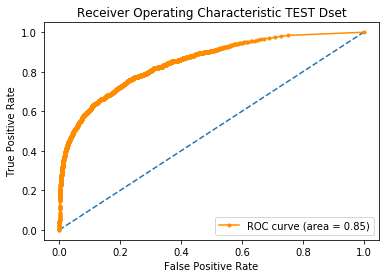

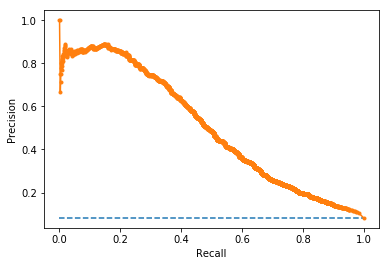

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_10 ROC-AUC: 0.849 PR-AUC: 0.502
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_20 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_20.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_20.json from disk
14572/14572 [==============================] - 9s 613us/step
(2634,) (2634,)


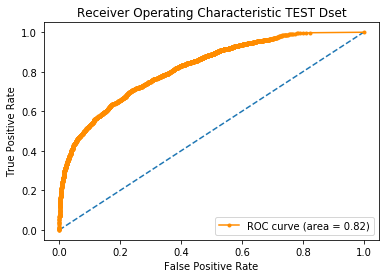

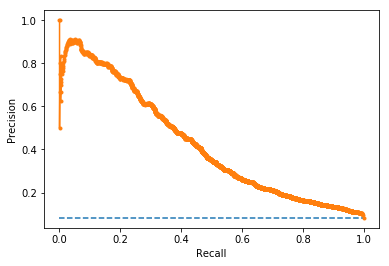

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_20 ROC-AUC: 0.821 PR-AUC: 0.426
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_30 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_30.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_30.json from disk
14572/14572 [==============================] - 9s 623us/step
(2283,) (2283,)


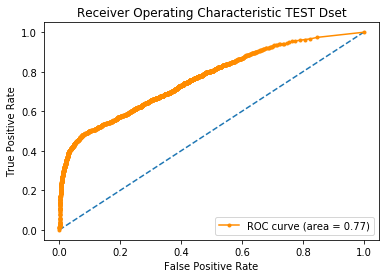

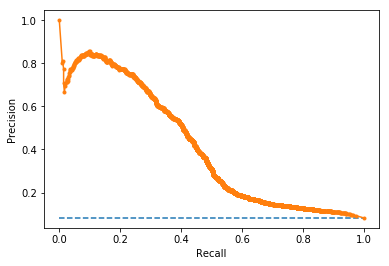

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_30 ROC-AUC: 0.766 PR-AUC: 0.408
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_40 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_40.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_40.json from disk
14572/14572 [==============================] - 9s 624us/step
(2212,) (2212,)


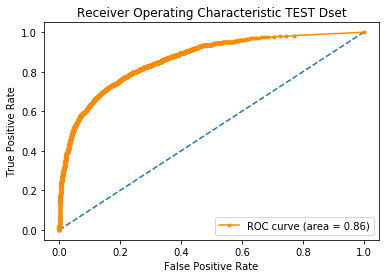

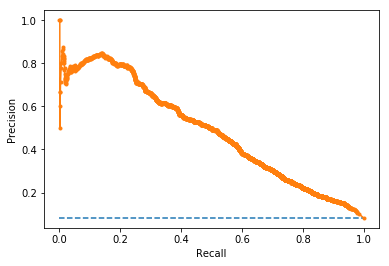

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_40 ROC-AUC: 0.864 PR-AUC: 0.485
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_50 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_50.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_50.json from disk
14571/14571 [==============================] - 9s 624us/step
(2490,) (2490,)


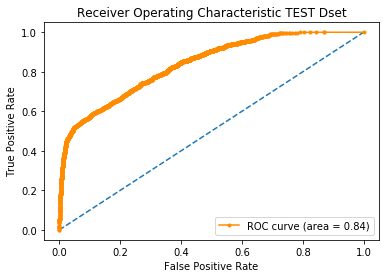

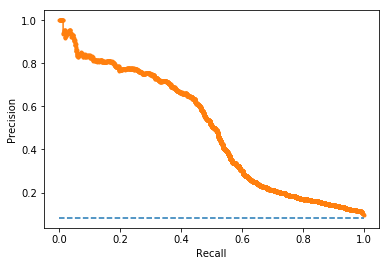

(58288, 128, 1) (58288, 1) (14571, 128, 1) (14571, 1)
Abnormal:  1196.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_32_5_50 ROC-AUC: 0.838 PR-AUC: 0.490
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_10 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_10.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_10.json from disk
14572/14572 [==============================] - 7s 452us/step
(2433,) (2433,)


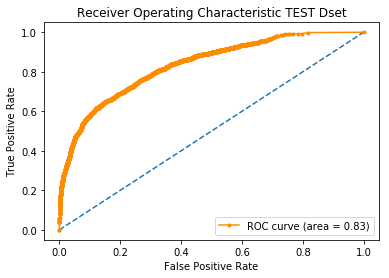

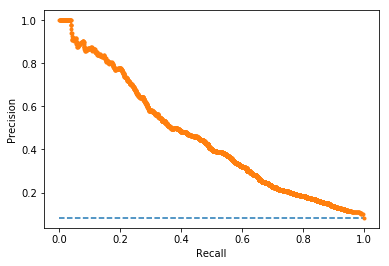

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_10 ROC-AUC: 0.835 PR-AUC: 0.453
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_20 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_20.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_20.json from disk
14572/14572 [==============================] - 7s 473us/step
(2434,) (2434,)


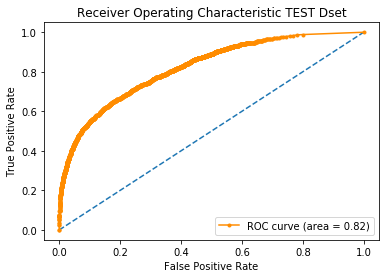

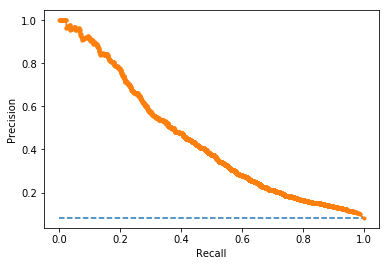

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_20 ROC-AUC: 0.822 PR-AUC: 0.443
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_30 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_30.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_30.json from disk
14572/14572 [==============================] - 7s 464us/step
(2510,) (2510,)


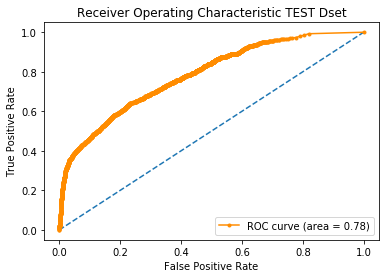

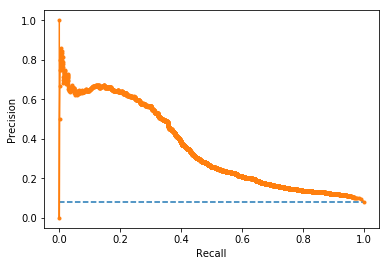

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_30 ROC-AUC: 0.784 PR-AUC: 0.353
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_40 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_40.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_40.json from disk
14572/14572 [==============================] - 7s 466us/step
(2554,) (2554,)


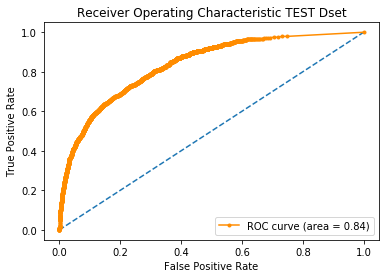

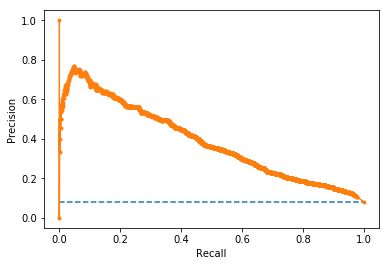

(58287, 128, 1) (58287, 1) (14572, 128, 1) (14572, 1)
Abnormal:  1197.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_40 ROC-AUC: 0.836 PR-AUC: 0.387
Testing 200 epochs UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_50 please wait until finished
Loaded model-DNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_50.h5 and weightDNN_CLUA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_50.json from disk
14571/14571 [==============================] - 7s 470us/step
(2449,) (2449,)


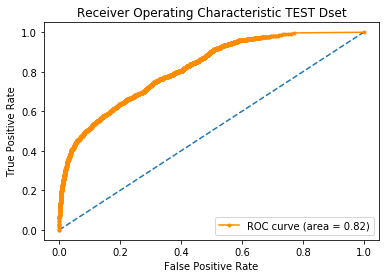

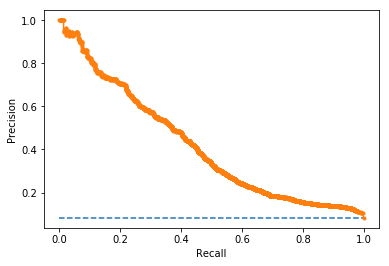

(58288, 128, 1) (58288, 1) (14571, 128, 1) (14571, 1)
Abnormal:  1196.0  Normal:  13375.0 UA09-200X-SERI-WITH-NORMAL-MODEL_1_1024_hard_sigmoid_64_5_50 ROC-AUC: 0.817 PR-AUC: 0.417


In [26]:

#kalau n_input=7 dan n_out=7 artinya input 7 hari, output 7 hari ke depan (label)
#This to_supervised3 function from machinelearningmastery Jason Brownlee, Ph.D.
def to_supervised3(X, y, train, label, n_input, n_pred_out=7): 
	# flatten data
	data = train #.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	#X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_pred_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end]); maxlabel = max(label[in_end:out_end])
			y.append(maxlabel) #only one label
		# move along one time step
		in_start += 1
	return array(X), array(y)


#%%
#IMPORTANT VARIABLES !!!!AS FEATURES
#I hope your machine has enough resources

#Sapdo, check this Dir
#DIR = './/DNN_MODEL_WEIGHT/'
DIR = './'

#auc_roc_pr[INTERVAL, N_PRED_OUT, cluster_no,n_crossvalidation, SPLIT_NO, roc-pr-auc]
auc_roc_pr = np.zeros((3,3,4,3,10,5,6))
ii=jj=kk=ll=0
INTERVAL =128
N_PRED_OUT=14
N_OUT = 1
for LSTM_LAYERS in [1]: #ONLY TESTED FOR 3 LAYERS [1,2,3]
    for NEURON in [1024]: #[64,256,1024]
        for ACT_FUN in ['hard_sigmoid']: #['tanh', 'sigmoid', 'relu', 'hard_sigmoid']
            for CONV1D in [32,64]:
                
                
                X0,y0 = list(), list()
                to_supervised3(X0, y0, values_seri, xn_seri, INTERVAL, N_PRED_OUT)

                X0 = np.array(X0) #make sure all in numpys, not in lists
                y0 = np.array(y0)
                y0 = y0.reshape((y0.shape[0],1)) #make shape to (n_labels,1)


                #DataValueLabel = np.append(X0,y0, axis=1)

                # Change the variabel data  --> data = DataVAlueLabel1/2/3/blank
                NUMCLASSMEMBERS = 1 # only using 1 features
                SPLIT_NO = 0

                DataNonSmoteX = X0
                DataNonSmotey = y0

                n_crossvalidation=5
                skf = StratifiedKFold(n_splits=n_crossvalidation)
                train_all=[]
                test_all=[]
                for train, test in skf.split(DataNonSmoteX, DataNonSmotey):
                    train_all.append(train)
                    test_all.append(test)
                for SPLIT_NO in range(n_crossvalidation):
                    if (ACT_FUN==32) and (CONV1D==32) and (SPLIT_NO in [0,1,2]) :
                        continue
                    Data2kCrossValTrainx = DataNonSmoteX[train_all[SPLIT_NO]]
                    Data2kCrossValTrainy = DataNonSmotey[train_all[SPLIT_NO]]
                    w1 = np.where(Data2kCrossValTrainy==1)
                    RANDOM_INDEX = random.sample(range(Data2kCrossValTrainx.shape[0]),Data2kCrossValTrainx.shape[0])
                    Data2kCrossValTrainx = Data2kCrossValTrainx[RANDOM_INDEX]
                    Data2kCrossValTrainy = Data2kCrossValTrainy[RANDOM_INDEX]


                    Data2kCrossValTestx = DataNonSmoteX[test_all[SPLIT_NO]]
                    Data2kCrossValTesty = DataNonSmotey[test_all[SPLIT_NO]]
                    w0 = np.where(Data2kCrossValTesty==1)
                    RANDOM_INDEX = random.sample(range(Data2kCrossValTestx.shape[0]),Data2kCrossValTestx.shape[0])
                    Data2kCrossValTestx = Data2kCrossValTestx[RANDOM_INDEX]
                    Data2kCrossValTesty = Data2kCrossValTesty[RANDOM_INDEX]
                    Data2kCrossValTestx = Data2kCrossValTestx.reshape((Data2kCrossValTestx.shape[0],Data2kCrossValTestx.shape[1],1))
                    #print( len(w1[0]), len(w0[0]))

                    #sm = SMOTE(random_state=42)
                    #X = DataValueLabel3[:,:INTERVAL]
                    #y = DataValueLabel3[:,INTERVAL]
                    #X_res, y_res = sm.fit_resample(X, y)
                    #print('Resampled dataset shape %s' % Counter(y_res))
                    SMOTE_IN = False #True #if u want to use SMOTE
                    if (SMOTE_IN) :
                        sm = SMOTE(random_state=42)
                        X = Data2kCrossValTrainx
                        y = Data2kCrossValTrainy
                        X_res, y_res = sm.fit_resample(X, y)
                        print('SPLIT NO: ',SPLIT_NO, 'Resampled dataset shape %s' % Counter(y_res))

                        y=y_res.reshape(y_res.shape[0],1) #format ke y(:,1)
                        #Random data first than combine. DataSmote = np.append(X_res,y, axis=1) # append supaya jadi [Xy] 
                        DataSmoteX= X_res
                        DataSmotey = y
                        RANDOM_INDEX = random.sample(range(DataSmoteX.shape[0]),DataSmoteX.shape[0])


                        #print(RANDOM_INDEX)
                        DataSmoteX = DataSmoteX[RANDOM_INDEX]
                        DataSmotey = DataSmotey[RANDOM_INDEX]
                        #change to timeseries format data
                        DataSmoteX = DataSmoteX.reshape((DataSmoteX.shape[0],DataSmoteX.shape[1],1))

                        #Split Dataset
                        #tx, tsx, ytrain, ytest = train_test_split(DataSmoteX,DataSmotey, test_size=0.2, random_state=42)
                        tx = DataSmoteX
                        ytrain = DataSmotey
                        tsx = Data2kCrossValTestx
                        ytest = Data2kCrossValTesty
                    else:
                        Data2kCrossValTrainx = Data2kCrossValTrainx.reshape((Data2kCrossValTrainx.shape[0],Data2kCrossValTrainx.shape[1],1))    
                        tx = Data2kCrossValTrainx
                        ytrain = Data2kCrossValTrainy
                        tsx = Data2kCrossValTestx
                        ytest = Data2kCrossValTesty
                        #print(tx.shape, ytrain.shape, tsx.shape, ytest.shape)

                    N_TRAIN_MOVIES = tx.shape[0]
                    N_TEST_MOVIES = tsx.shape[0]
                    INTERVAL = tx.shape[1]


                    BATCHSIZE=90 * 4
                    model = Sequential()

                    
                    model.add(Conv1D(4, 3, strides=3, activation=ACT_FUN, input_shape=(INTERVAL, NUMCLASSMEMBERS)))
                    model.add(Conv1D(8, 3, padding="same",activation=ACT_FUN))
                    model.add(MaxPooling1D(1))
                    model.add(Conv1D(16, 5,padding="same", activation=ACT_FUN))
                    model.add(MaxPooling1D(1))
                    if CONV1D >= 2:
                        model.add(Conv1D(32, 7,padding="same", activation=ACT_FUN))
                        model.add(MaxPooling1D(3))
                    if CONV1D >=3 :
                        model.add(Conv1D(64, 7,padding="same", activation=ACT_FUN))
                        model.add(MaxPooling1D(3))
                    
                    model.add(Dropout(0.5))
                    
                    model.add(LSTM(NEURON, batch_input_shape=(BATCHSIZE,INTERVAL, NUMCLASSMEMBERS)))
                    if LSTM_LAYERS == 2:
                        model.add(LSTM(NEURON))    
                      
                    if LSTM_LAYERS == 3:
                        model.add(LSTM(NEURON, return_sequences=True))
                        model.add(LSTM(NEURON))    
                        
                    model.add(Dense(N_OUT, activation='sigmoid'))

                    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

                    EPOCH = 200
                    NO = 'UA09-200X-SERI-WITH-NORMAL-MODEL'+'_'+str(LSTM_LAYERS)+'_'+str(NEURON)+'_'+str(ACT_FUN)+'_'+str(CONV1D)+'_'+str(n_crossvalidation)+'_'+str(SPLIT_NO+1)+str(int(SMOTE_IN)) # 500 untuk 2 cluster[1] 

#Sapdo, I change STATUS = "LOAD" from STATUS = "SAVE" to do testing
                    STATUS = "LOAD" #or else i.e: 'LOAD'
                    #STATUS = "SAVE" #or else i.e: 'LOAD'

                    if STATUS == "SAVE" :
                        print("ONLY LOAD NO SAVE NO MODEL")
                        

                    else : #test = "Load" # load json and create model
                        print('Testing ' + str(EPOCH) +' epochs '+ NO  +' please wait until finished')
                        json_file = open(DIR + "DNN_CL"+ NO +".json", 'r')
                        loaded_model_json = json_file.read()
                        json_file.close()
                        model = model_from_json(loaded_model_json)
                        # load weights into new model
                        model.load_weights(DIR + "DNN_CL"+ NO +".h5")
                        print("Loaded model-" + "DNN_CL"+ NO +".h5" + " and weight"+"DNN_CL"+ NO +".json"+" from disk")

                    probs = model.predict(tsx, verbose=1)
                    # calculate AUC
                    rocauc = roc_auc_score(ytest, probs)
                    # calculate roc curve
                    fpr, tpr, thresholds = roc_curve(ytest, probs)
                    ## plot naive
                    plt.plot([0, 1], [0, 1], linestyle='--')
                    ## plot the roc curve for the model
                    plt.plot(fpr, tpr, marker='.',color='darkorange', label='ROC curve (area = %0.2f)' % rocauc)
                    print(tpr.shape,fpr.shape)
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic TEST Dset')
                    plt.legend(loc="lower right")
                    ## show the plot
                    plt.savefig("./cluster_pdf/"+NO+"-ROC.png")
                    plt.show()

                    ##PRECISION RECALL TESTING
                    pos = np.sum(ytest)
                    neg = ytest.shape[0]-pos
                    precision, recall, thresholds = precision_recall_curve(ytest, probs)
                    auc_score = auc(recall, precision)
                    pyplot.plot([0, 1], [pos/ytest.shape[0], pos/ytest.shape[0]], linestyle='--')
                    pyplot.plot(recall, precision, marker='.')
                    plt.xlabel('Recall')
                    plt.ylabel('Precision')
                    plt.savefig("./cluster_pdf/"+NO+"-PR.png")
                    pyplot.show()
                    print(tx.shape, ytrain.shape, tsx.shape, ytest.shape)
                    print('Abnormal: ',str(pos), ' Normal: ', str(neg), NO,'ROC-AUC: %.3f' % rocauc, 'PR-AUC: %.3f' % auc_score)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,0] = rocauc
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,1] = auc_score
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,2] = np.sum(ytest==1)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,3] = np.sum(ytest==0)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,4] = np.sum(ytrain==1)
                    auc_roc_pr[ii,jj,kk,ll,n_crossvalidation,SPLIT_NO,5] = np.sum(ytrain==0)              
                    

                    del model
                ll=ll+1 #conv1d=16,32,64
            kk=kk+1 #act_fun = tanh, sigmoid, relu, hard_sigmoid
            ll=0
        jj=jj+1 # untuk menyimpan NEURON NUMBER = 64,128,256,512,1024
        kk=0
    jj=0
    ii=ii+1 # untuk menyimpan LSTM LAYERS =1,2,3
        


In [27]:
#probs = model.predict(tsx, verbose=1)
# calculate AUC
rocauc = roc_auc_score(ytest, probs)
# calculate roc curve
fpr, tpr, rocthresholds = roc_curve(ytest, probs)


In [28]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = rocthresholds[optimal_idx]

In [29]:
optimal_idx, optimal_threshold

(958, 0.0023083985)

In [30]:
optimal_idx, tpr[optimal_idx], fpr[optimal_idx]

(958, 0.6596989966555183, 0.2217570093457944)

In [31]:
probTF = (probs > 0.962).astype(int)
prediction_storage = probTF
label = ytest
TP=TN=FP=FN=0
for i in range(probTF.shape[0]):
    if (prediction_storage[i] ==1) and (label[i] == 1): 
        TP = TP+1
    if (prediction_storage[i] ==0) and (label[i] == 0): 
        TN = TN+1
    if (prediction_storage[i] ==1) and (label[i] == 0): 
        FP = FP+1
    if (prediction_storage[i] ==0) and (label[i] == 1): 
        FN = FN+1
tpr_val = TP/(TP+FN)
fpr_val = FP/(FP+TN)
precision_val = TP/(TP+FP)


print("TP= %5d" %TP,"TN= %5d" %TN,"FP= %5d" %FP,"FN= %5d" %FN,"TPR= %.3f" %tpr_val,"FPR= %.3f" %fpr_val,"PRECISION= %.3f" %precision_val, 
     "RECALL= %.3f" %tpr_val)

TP=   265 TN= 13248 FP=   127 FN=   931 TPR= 0.222 FPR= 0.009 PRECISION= 0.676 RECALL= 0.222


(2449,) (2449,)


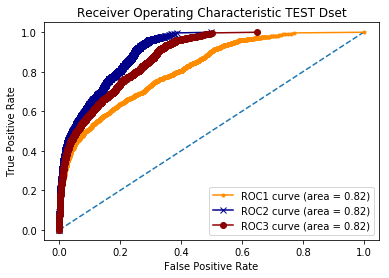

In [32]:
tpr1 = tpr2=tpr3=tpr
fpr1= fpr2= fpr3=fpr

plt.plot([0, 1], [0, 1], linestyle='--')
## plot the roc curve for the model
plt.plot(fpr1, tpr1, marker='.',color='darkorange', label='ROC1 curve (area = %0.2f)' % rocauc)
plt.plot(fpr2*0.5, tpr2, marker='x',color='darkblue', label='ROC2 curve (area = %0.2f)' % rocauc)
plt.plot(fpr3*0.65, tpr3, marker='o',color='darkred', label='ROC3 curve (area = %0.2f)' % rocauc)
print(tpr.shape,fpr.shape)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic TEST Dset')
plt.legend(loc="lower right")
## show the plot
plt.show()


In [33]:
tprlist = list()
tprlist.append(tpr1)
tprlist.append(tpr2)
tprlist.append(tpr3)

In [34]:
tprlist[1].shape

(2449,)